# Import Libraries


In [290]:
# Importing Libraries
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from unidecode import unidecode
import re
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Download Stopwords


In [291]:
# Download Stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

# Load the Dataset


In [292]:
# Loading the dataset
dataset = pd.read_csv('hate_speech_dataset.csv')
dataset.head()

,text,label
0,"Eke, the python, silently slithers through the...",0
1,"Nkịta, the dog, barks loudly to alert its owner.",0
2,"Ewu, the goat, grazes peacefully in the meadow.",0
3,"Ọkụkọ, the chicken, clucks while searching for...",0
4,"Enyi, the elephant, majestically walks through...",0


# Data Preprocessing


### Cleaning the data


In [293]:
# Cleaning the data
def clean_and_remove_special_chars(text):
    # Remove accents and convert non-English characters
    text = unidecode(text)

    # Remove special characters and digits using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text


# Apply cleaning to the entire 'text' column
dataset['cleaned_text'] = dataset['text'].apply(clean_and_remove_special_chars)

# Display the cleaned dataset
print(dataset[['text', 'cleaned_text']].head())

                                                text  \
0  Eke, the python, silently slithers through the...   
1   Nkịta, the dog, barks loudly to alert its owner.   
2    Ewu, the goat, grazes peacefully in the meadow.   
3  Ọkụkọ, the chicken, clucks while searching for...   
4  Enyi, the elephant, majestically walks through...   

                                        cleaned_text  
0  Eke the python silently slithers through the g...  
1      Nkita the dog barks loudly to alert its owner  
2       Ewu the goat grazes peacefully in the meadow  
3  Okuko the chicken clucks while searching for food  
4  Enyi the elephant majestically walks through t...  


# Visualize Cleaned Data


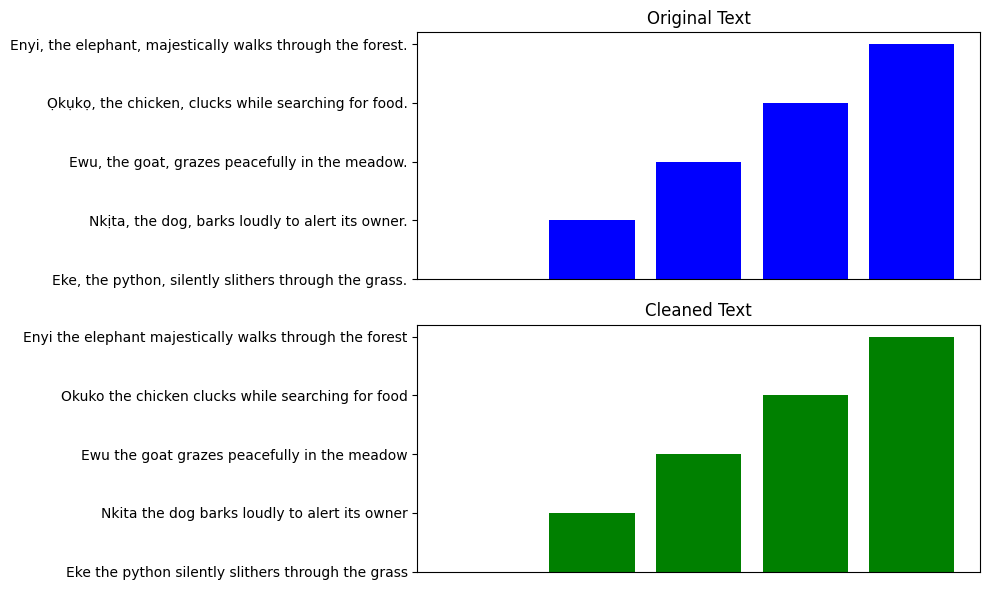

In [294]:
# Original and cleaned text
original_text = dataset['text'].iloc[:5].values
cleaned_text = dataset['cleaned_text'].iloc[:5].values

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Original text
axes[0].bar(range(len(original_text)), original_text, color='blue')
axes[0].set_title('Original Text')
axes[0].set_xticks([])  # Hide x-axis ticks for better readability

# Cleaned text
axes[1].bar(range(len(cleaned_text)), cleaned_text, color='green')
axes[1].set_title('Cleaned Text')
axes[1].set_xticks([])  # Hide x-axis ticks for better readability

plt.tight_layout()
plt.show()

### Tokenization and Lemmatization


In [295]:
# Tokenization and Lemmatization
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower(
    ) not in stopwords.words('english')]

    return ' '.join(tokens)


# Apply tokenization and lemmatization to the 'cleaned_text' column
dataset['processed_text'] = dataset['cleaned_text'].apply(preprocess_text)

# Display the dataset with the processed text
dataset.head()

,text,label,cleaned_text,processed_text
0,"Eke, the python, silently slithers through the...",0,Eke the python silently slithers through the g...,eke python silently slithers grass
1,"Nkịta, the dog, barks loudly to alert its owner.",0,Nkita the dog barks loudly to alert its owner,nkita dog bark loudly alert owner
2,"Ewu, the goat, grazes peacefully in the meadow.",0,Ewu the goat grazes peacefully in the meadow,ewu goat graz peacefully meadow
3,"Ọkụkọ, the chicken, clucks while searching for...",0,Okuko the chicken clucks while searching for food,okuko chicken cluck searching food
4,"Enyi, the elephant, majestically walks through...",0,Enyi the elephant majestically walks through t...,enyi elephant majestically walk forest


# Visualize Tokenization


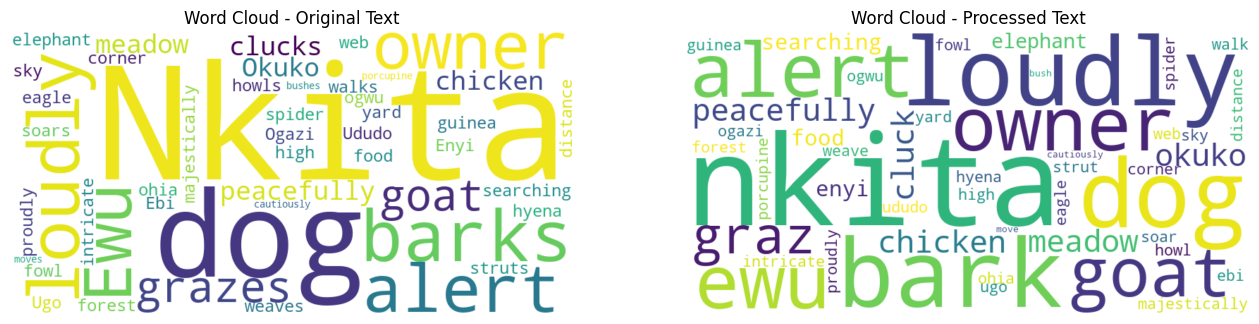

In [296]:
# Original and processed text
original_text = ' '.join(dataset['cleaned_text'].iloc[1:10].values)
processed_text = ' '.join(dataset['processed_text'].iloc[1:10].values)

# Generate word clouds
wordcloud_original = WordCloud(
    width=800, height=400, background_color='white').generate(original_text)
wordcloud_processed = WordCloud(
    width=800, height=400, background_color='white').generate(processed_text)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Original text word cloud
axes[0].imshow(wordcloud_original, interpolation='bilinear')
axes[0].set_title('Word Cloud - Original Text')
axes[0].axis('off')

# Processed text word cloud
axes[1].imshow(wordcloud_processed, interpolation='bilinear')
axes[1].set_title('Word Cloud - Processed Text')
axes[1].axis('off')

plt.show()

# Vectorization


In [297]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# Create a TF-IDF vectorizer
# You can adjust max_features based on your vocabulary size
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer with the entire corpus
vectorizer.fit(dataset['processed_text'])

# Vectorize individual strings in processed_text
X = []
for text in dataset['processed_text']:
    # Transform each individual string using the same vocabulary
    vectorized_text = vectorizer.transform([text]).toarray()
    X.append(vectorized_text)

# Concatenate the individual vectors into a NumPy array
X = np.vstack(X)

# Replace with your labels
y = dataset['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Display the shape of the vectors and labels
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (214, 668)
Shape of X_test: (54, 668)
Shape of y_train: (214,)
Shape of y_test: (54,)


# Visualize Vectorization


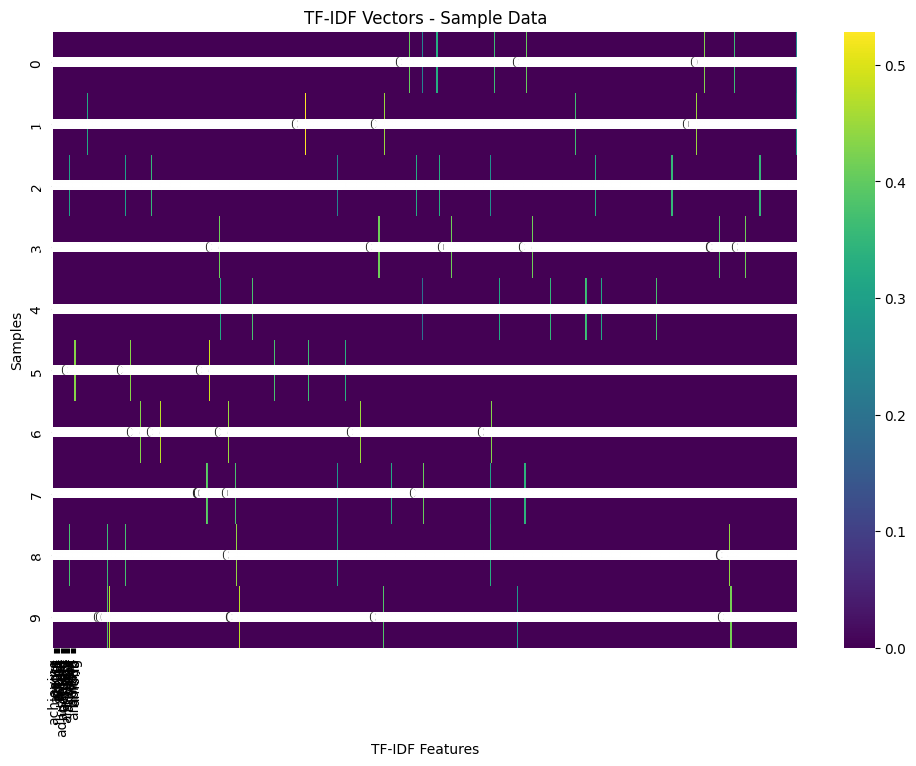

In [298]:
# Display the heatmap for the TF-IDF vectors
plt.figure(figsize=(12, 8))
sns.heatmap(X_train[:10, :], cmap='viridis', annot=True,
            fmt=".2f", xticklabels=vectorizer.get_feature_names_out()[:20])
plt.title('TF-IDF Vectors - Sample Data')
plt.xlabel('TF-IDF Features')
plt.ylabel('Samples')
plt.show()

# Model Architecture


Epoch 1/10
6/6 [==============================] - 1s 38ms/step - loss: 0.6828 - accuracy: 0.5848 - val_loss: 0.6757 - val_accuracy: 0.6047
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6550 - accuracy: 0.6082 - val_loss: 0.6607 - val_accuracy: 0.6047
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6284 - accuracy: 0.6725 - val_loss: 0.6442 - val_accuracy: 0.6279
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.5994 - accuracy: 0.7661 - val_loss: 0.6270 - val_accuracy: 0.6279
Epoch 5/10
6/6 [==============================] - 0s 10ms/step - loss: 0.5679 - accuracy: 0.8596 - val_loss: 0.6073 - val_accuracy: 0.6279
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 0.5333 - accuracy: 0.9240 - val_loss: 0.5857 - val_accuracy: 0.6279
Epoch 7/10
6/6 [==============================] - 0s 13ms/step - loss: 0.4951 - accuracy: 0.9591 - val_loss: 0.5632 - val_accuracy: 0.6512
Epoch 8/10
6/6 [===============

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


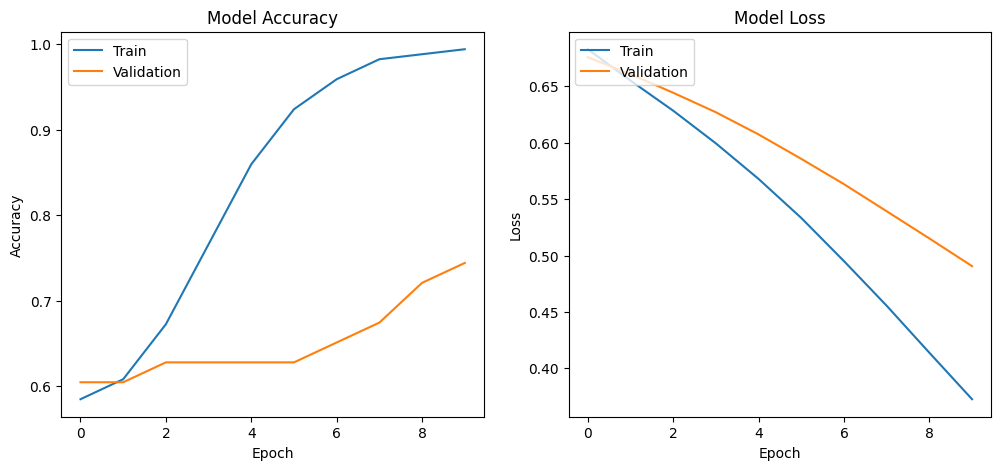

2/2 [==============================] - 0s 0s/step


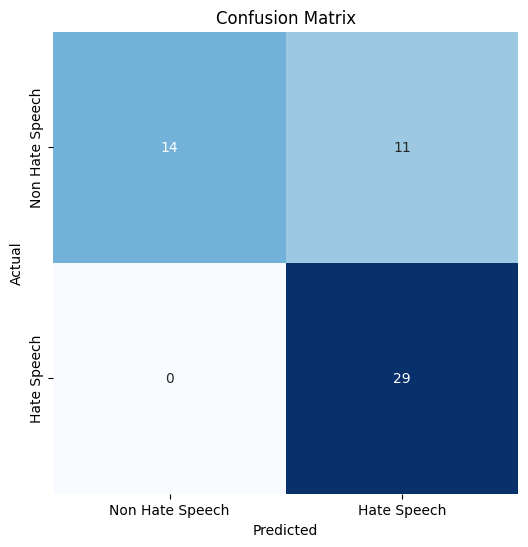

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72        25
           1       0.72      1.00      0.84        29

    accuracy                           0.80        54
   macro avg       0.86      0.78      0.78        54
weighted avg       0.85      0.80      0.78        54



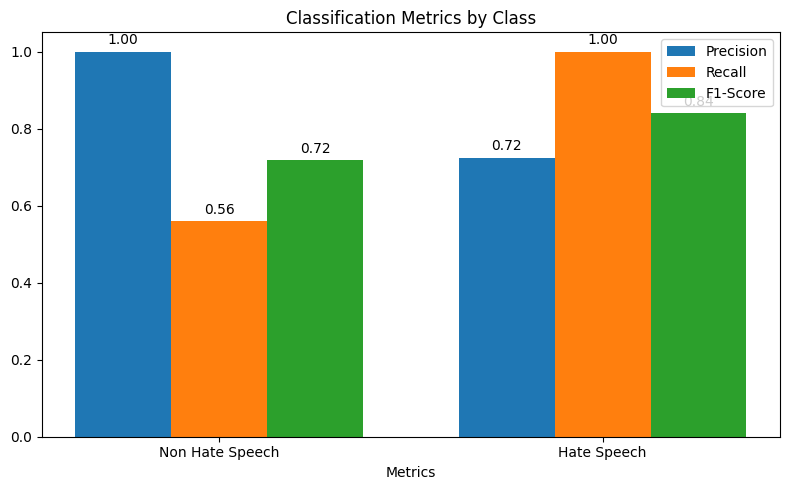

In [299]:
# Define the Sequential model
model = Sequential()

# Add a Dense layer with 128 units and 'relu' activation function (you can adjust as needed)
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# Add an output layer with 1 unit and 'sigmoid' activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10,
                    batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

model.save('hspeechmodel.h5')

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Visualize training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Non Hate Speech', 'Hate Speech'], yticklabels=['Non Hate Speech', 'Hate Speech'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Get classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Extract precision, recall, and F1-score values
precision = [report[label]['precision']
             for label in report.keys() if label in ['0', '1']]
recall = [report[label]['recall']
          for label in report.keys() if label in ['0', '1']]
f1_score = [report[label]['f1-score']
            for label in report.keys() if label in ['0', '1']]

# Labels for the bars
labels = ['Non Hate Speech', 'Hate Speech']

# Plotting
x = np.arange(len(labels))
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Metrics')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the values on top of the bars


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()